In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tueplots import figsizes, bundles
import seaborn as sns
import colorcet as cc
import json
from plotting_utils import read_data_from_logs, clean_results, check_if_minimized
from performance_profile import BASE_WORKLOADS

In [40]:
# Open json file to read heldout workloads
with open("held_out_workloads_algoperf_v05.json", "r") as f:
  HELDOUT_WORKLOADS = json.load(f)

SELF_TUING = True

log_path = "../../submissions_algorithms_v0.5/logs/algoperf_scoring_v05/"
if SELF_TUING:
  log_path = os.path.join(log_path, "self_tuning")
else:
  log_path = os.path.join(log_path, "external_tuning")

full_results = read_data_from_logs(log_path)
clean_results_df = clean_results(full_results)

Reading data for submission: prize_qualification_baseline
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_init_jax', 'imagenet_resnet_jax']
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_init_jax', 'imagenet_resnet_jax']
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_i

In [41]:
def get_train_loss_at_target(row):
    target = row['performance_target']
    performance = row['performance']
    train_loss = row['train_loss']
    # assert len(performance) == len(train_loss), "Performance and train_loss must have the same length"
    
    # Ensure performance and train_loss are lists or numpy arrays
    if not isinstance(performance, (list, np.ndarray)):
        performance = [performance]
    if not isinstance(train_loss, (list, np.ndarray)):
        train_loss = [train_loss]
    
    # The column "perf_is_minimized" is True if the performance metric is minimized otherwise it should be maximized,
    # this changes the comparison operator when checking if the target has been reached
    is_minimized = check_if_minimized(row['validation_metric'])

    # Choose the comparison operator based on whether we're minimizing or maximizing
    # Find the first index where performance exceeds the target
    if is_minimized:
        exceeding_indices = np.where(np.array(performance) < target)[0]
    else:
        exceeding_indices = np.where(np.array(performance) > target)[0]

    # Return the train loss at the first index where the target is exceeded
    if len(exceeding_indices) > 0:
        return train_loss[exceeding_indices[0]]
    else:
        return np.nan

# Apply the function to create the new column
for submission_name, submission_results in clean_results_df.items():
    df = clean_results_df[submission_name]
    # Drop all rows where the workload is not a base or heldout workload
    df = df[df['workload'].isin(BASE_WORKLOADS + HELDOUT_WORKLOADS)]

    # Only consider base workloads
    df = df[df['workload'].isin(BASE_WORKLOADS)]
    
    df['train_loss_at_target'] = df.apply(get_train_loss_at_target, axis=1)
    clean_results_df[submission_name] = df

In [42]:
BENCHMARK_SCORE = {
    "schedule_free_adamw": 0.8542,
    "prize_qualification_baseline": 0.8194,
    "nadamw_sequential": 0.3308,
    "sinv6_75": 0.1420,
    "sinv6": 0.0903,
    "AdamG": 0.0,   
} if SELF_TUING else {
    "shampoo_submission": 0.7784,
    "schedule_free_adamw": 0.7077,
    "generalized_adam": 0.6383,
    "cyclic_lr": 0.6301,
    "nadamp": 0.5909,
    "prize_qualification_baseline": 0.799,
    "amos": 0.4918,
    "caspr_adaptive": 0.4722,
    "lawa_queue": 0.3699,
    "lawa_ema": 0.3384,
    "schedule_free_prodigy": 0.0,
}

def transpose_submission_to_workload(submission_dict):
    # Create a dictionary to store DataFrames by workload
    workload_dict = {}

    # Iterate through each submission and its DataFrame
    for submission, df in submission_dict.items():
        # Add a 'submission' column to identify the source
        df['submission'] = submission

        # Add a 'benchmark_score' column with the submission's score
        df['benchmark_score'] = BENCHMARK_SCORE[submission]
        
        # Group the DataFrame by workload
        grouped = df.groupby('workload')
        
        # For each workload in this submission
        for workload, group in grouped:
            if workload not in workload_dict:
                # If this is a new workload, create a new DataFrame
                workload_dict[workload] = group
            else:
                # If the workload already exists, concatenate the new data
                workload_dict[workload] = pd.concat([workload_dict[workload], group])

    # Reset index for all DataFrames in the workload dictionary
    for workload in workload_dict:
        workload_dict[workload] = workload_dict[workload].reset_index(drop=True)

    return workload_dict

transposed_results = transpose_submission_to_workload(clean_results_df)

In [43]:
# For each workload, normalized the train_loss_at_target column to be between 0 and 1
for workload in transposed_results:
    transposed_results[workload]['relative_train_loss_at_target'] = (transposed_results[workload]['train_loss_at_target'] - transposed_results[workload]['train_loss_at_target'].min()) / (transposed_results[workload]['train_loss_at_target'].max() - transposed_results[workload]['train_loss_at_target'].min())

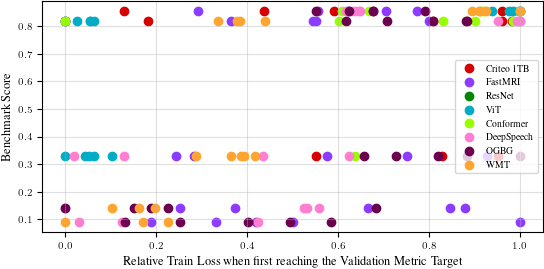

In [44]:
with plt.rc_context(
    {**bundles.iclr2024(), **figsizes.iclr2024(height_to_width_ratio=1)}):
    fig, ax = plt.subplots()
    # For each workload, plot the train loss at target (x-axis) vs. benchmark score (y-axis)
    # Give each workload a different color
    palette = sns.color_palette(cc.glasbey, n_colors=len(transposed_results))

    # Iterate through each workload and plot
    for idx, workload in enumerate(transposed_results):
        ax.scatter(transposed_results[workload]['relative_train_loss_at_target'], transposed_results[workload]['benchmark_score'], label=workload, color=palette[idx])

    # Apply dictionary to rename legend labels
    workload_rename_dict = {
        "criteo1tb": "Criteo 1TB",
        "fastmri": "FastMRI",
        "imagenet_resnet": "ResNet",
        "imagenet_vit": "ViT",
        "librispeech_conformer": "Conformer",
        "librispeech_deepspeech": "DeepSpeech",
        "ogbg": "OGBG",
        "wmt": "WMT",
    }
    # Rename the legend labels
    handles, labels = ax.get_legend_handles_labels()

    # Map the labels through the dictionary
    new_labels = [workload_rename_dict.get(label, label) for label in labels]
    
    # Create a new legend with the mapped labels
    ax.legend(handles, new_labels)

    plt.xlabel('Relative Train Loss when first reaching the Validation Metric Target')
    plt.ylabel('Benchmark Score')


    filename = "plots/opt_vs_regularize"
    filename += "_self_tuning" if SELF_TUING else "_external_tuning"
    
    plt.savefig(f"{filename}.png")
    plt.show()